In [ ]:
import os
from google.colab import drive
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel
import torch
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!ls "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages"


downloads  wiki40b


In [ ]:
base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
languages = [name for name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, name)) and not name.startswith('.')]
print("Languages:", languages)

Languages: ['da', 'en', 'de', 'ru', 'fr', 'es', 'it', 'pt', 'nl', 'hu', 'sv', 'fi', 'no', 'ro', 'tr']


In [ ]:
def read_tfrecord(language, split='test'):
    path_pattern = f"{base_path}/{language}/{split}.tfrecord-*"
    raw_dataset = tf.data.TFRecordDataset(tf.io.gfile.glob(path_pattern))
    return raw_dataset


In [ ]:
def parse_tfrecord(serialized_example):
    feature_description = {
        'text': tf.io.FixedLenFeature([], tf.string),
        # Add other features here if necessary
    }
    return tf.io.parse_single_example(serialized_example, feature_description)


dataset = read_tfrecord('en').map(parse_tfrecord)
print(dataset)

<_MapDataset element_spec={'text': TensorSpec(shape=(), dtype=tf.string, name=None)}>


In [ ]:
# Using TF-IDF (consider more sophisticated methods for actual implementation)

# Function to vectorize documents
def vectorize_documents(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    return tfidf_matrix, vectorizer


#   Count Documents Across All Shards:
#   The code below iterates through the language folders, reads all TFRecord shard files for each of the train, test, and validation splits, and sums up the document counts.

#    Aggregate and Visualize:
#    After counting, it aggregates these counts by language and visualizes them using a bar chart to compare the document availability across languages.

In [ ]:

base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
languages = ['da', 'en', 'de', 'ru', 'fr', 'es', 'it', 'pt', 'nl', 'hu', 'sv', 'fi', 'no', 'ro', 'tr']

def count_documents_in_tfrecord(file_paths):
    count = 0
    for file_path in file_paths:
        dataset = tf.data.TFRecordDataset(file_path)
        file_count = sum(1 for _ in dataset)
        count += file_count
        print(f"Processed {file_path}: {file_count} documents.")
    return count

document_counts = {}
for language in languages:
    print(f"Processing language: {language}")
    language_path = os.path.join(base_path, language, "1.3.0")  # Adjusting for the versioned subfolder
    splits = ['train', 'test', 'validation']
    for split in splits:
        file_pattern = os.path.join(language_path, f"wiki40b-{split}.tfrecord-*")
        files = tf.io.gfile.glob(file_pattern)
        if not files:
            print(f"No files found for {language} in {split} split.")
            continue
        if split not in document_counts:
            document_counts[split] = {}
        document_counts[split][language] = count_documents_in_tfrecord(files)
        print(f"Total documents in {split} split for {language}: {document_counts[split][language]}")

# Visualization
fig, ax = plt.subplots(figsize=(14, 8))
width = 0.25  # the width of the bars
ind = range(len(languages))  # the x locations for the groups

# Plot each split
for i, split in enumerate(splits):
    counts = [document_counts[split].get(lang, 0) for lang in languages]
    ax.bar([p + i*width for p in ind], counts, width, label=split)

ax.set_title('Number of Documents per Language and Split in Wiki40b')
ax.set_xticks([p + width for p in ind])
ax.set_xticklabels(languages)
ax.legend(splits, loc='upper left')
ax.autoscale_view()

plt.xticks(rotation=45)
plt.xlabel('Language')
plt.ylabel('Document Count')
plt.show()

Processing language: da
Processed /content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b/da/1.3.0/wiki40b-train.tfrecord-00001-of-00002: 54743 documents.


KeyboardInterrupt: 

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
model = AutoModel.from_pretrained("xlm-roberta-base")

def get_embedding(text):
    print(f"Tokenizing and encoding the text: {text[:20]}...")  # Print the first 20 characters
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    print("Generating embeddings...")
    with torch.no_grad():  # Ensure no gradients are computed to save memory and computations
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1)
    print("Embedding generated.")
    return embeddings

# Example usage
text_en = "Example text in English."
text_de = "Beispieltext auf Deutsch."
print("Processing English text...")
embedding_en = get_embedding(text_en)
print("Processing German text...")
embedding_de = get_embedding(text_de)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Processing English text...
Tokenizing and encoding the text: Example text in Engl...
Generating embeddings...
Embedding generated.
Processing German text...
Tokenizing and encoding the text: Beispieltext auf Deu...
Generating embeddings...
Embedding generated.


In [ ]:
similarity_score = cosine_similarity(embedding_en.detach().numpy(), embedding_de.detach().numpy())[0][0]
print(similarity_score)

0.9944985


In [ ]:
def extract_title(text):
    title_marker = "_START_ARTICLE_"
    end_marker = " _START_PARAGRAPH_"
    start = text.find(title_marker) + len(title_marker)
    end = text.find(end_marker)
    title = text[start:end].strip() if start != -1 and end != -1 else "No Title Found"
    return title

found_match = False

for _, row in df_small_lang.iterrows():
    wikidata_id = row['wikidata_id']
    matching_docs = df_en[df_en['wikidata_id'] == wikidata_id]

    if not matching_docs.empty:
        # Extract titles
        title_small_lang = extract_title(row['text'])
        title_en = extract_title(matching_docs.iloc[0]['text'])

        print(f"Match found:\n{title_small_lang} (Small Language) - {title_en} (English)")
        found_match = True
        break

if not found_match:
    print("No matching documents found.")

NameError: name 'df_small_lang' is not defined

In [ ]:
import tensorflow as tf
import os

def parse_tfrecord(example_proto):
    # Parse the input tf.train.Example proto using the dictionary below
    feature_description = {
        'wikidata_id': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def extract_wikidata_ids_from_tfrecords(file_paths):
    wikidata_ids = []
    for file_path in file_paths:
        dataset = tf.data.TFRecordDataset(file_path)
        for raw_record in dataset.map(parse_tfrecord):
            wikidata_id = raw_record['wikidata_id'].numpy().decode('utf-8')
            wikidata_ids.append(wikidata_id)
    return wikidata_ids

def find_matching_wikidata_ids(base_path, source_lang, target_lang):
    source_file_paths = tf.io.gfile.glob(f"{base_path}/{source_lang}/1.3.0/*.tfrecord-*")
    target_file_paths = tf.io.gfile.glob(f"{base_path}/{target_lang}/1.3.0/*.tfrecord-*")

    source_ids = extract_wikidata_ids_from_tfrecords(source_file_paths)
    target_ids = extract_wikidata_ids_from_tfrecords(target_file_paths)

    # Find intersection of WikiData IDs
    matching_ids = set(source_ids) & set(target_ids)

    print(f"Found {len(matching_ids)} matching WikiData IDs between {source_lang} and {target_lang}.")
    return matching_ids

# Example usage:
base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
source_lang = 'da'
target_lang = 'en'

matching_wikidata_ids = find_matching_wikidata_ids(base_path, source_lang, target_lang)
print(f"Sample of matching WikiData IDs: {list(matching_wikidata_ids)[:5]}")  # Print sample of 5 matching IDs


Found 70316 matching WikiData IDs between da and en.
Sample of matching WikiData IDs: ['Q1318941', 'Q234027', 'Q310146', 'Q16665941', 'Q181776']


In [ ]:
def parse_tfrecord_for_id_and_text(example_proto):
    # Parse the input tf.train.Example proto using the dictionary below
    feature_description = {
        'wikidata_id': tf.io.FixedLenFeature([], tf.string),
        'text': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def extract_title_from_text(text):
    start_article = '_START_ARTICLE_'
    start_paragraph = '_START_PARAGRAPH_'
    title_start_index = text.find(start_article) + len(start_article)
    title_end_index = text.find(start_paragraph)
    title = text[title_start_index:title_end_index].strip()
    return title

def print_titles_for_id(base_path, source_lang, target_lang, wikidata_id):
    source_file_paths = tf.io.gfile.glob(f"{base_path}/{source_lang}/1.3.0/*.tfrecord-*")
    target_file_paths = tf.io.gfile.glob(f"{base_path}/{target_lang}/1.3.0/*.tfrecord-*")

    for file_paths, lang in [(source_file_paths, source_lang), (target_file_paths, target_lang)]:
        for file_path in file_paths:
            dataset = tf.data.TFRecordDataset(file_path)
            for raw_record in dataset.map(parse_tfrecord_for_id_and_text):
                current_id = raw_record['wikidata_id'].numpy().decode('utf-8')
                if current_id == wikidata_id:
                    text = raw_record['text'].numpy().decode('utf-8')
                    title = extract_title_from_text(text)
                    print(f"Title in {lang} for ID {wikidata_id}: {title}")
                    break

# Example usage:
base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
source_lang = 'da'  # Danish
target_lang = 'en'  # English
wikidata_id = 'Q1318941'  # Example WikiData ID

print_titles_for_id(base_path, source_lang, target_lang, wikidata_id)



NameError: name 'tf' is not defined

In [ ]:
import tensorflow as tf

def parse_tfrecord_for_id_and_text(example_proto):
    feature_description = {
        'wikidata_id': tf.io.FixedLenFeature([], tf.string),
        'text': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def extract_title_from_text(text):
    start_article = '_START_ARTICLE_'
    start_paragraph = '_START_PARAGRAPH_'
    title_start_index = text.find(start_article) + len(start_article)
    title_end_index = text.find(start_paragraph)
    title = text[title_start_index:title_end_index].strip()
    return title

def find_matching_ids(base_path, language):
    file_paths = tf.io.gfile.glob(f"{base_path}/{language}/1.3.0/*.tfrecord-*")
    wikidata_ids = set()
    for file_path in file_paths:
        dataset = tf.data.TFRecordDataset(file_path)
        for raw_record in dataset.map(parse_tfrecord_for_id_and_text):
            wikidata_id = raw_record['wikidata_id'].numpy().decode('utf-8')
            wikidata_ids.add(wikidata_id)
    return wikidata_ids

def print_titles_for_matching_id(base_path, source_lang, target_lang, wikidata_ids):
    for wikidata_id in wikidata_ids:
        for lang in [source_lang, target_lang]:
            file_paths = tf.io.gfile.glob(f"{base_path}/{lang}/1.3.0/*.tfrecord-*")
            for file_path in file_paths:
                dataset = tf.data.TFRecordDataset(file_path)
                for raw_record in dataset.map(parse_tfrecord_for_id_and_text):
                    current_id = raw_record['wikidata_id'].numpy().decode('utf-8')
                    if current_id == wikidata_id:
                        text = raw_record['text'].numpy().decode('utf-8')
                        title = extract_title_from_text(text)
                        print(f"Title in {lang} for ID {wikidata_id}: {title}")
                        break  # Break after finding the first match
        break  # Break after printing titles for the first matching ID

# Example usage
base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
languages = ['da', 'en', 'de', 'ru', 'fr', 'es', 'it', 'pt', 'nl', 'hu', 'sv', 'fi', 'no', 'ro', 'tr']

# English wikidata IDs to compare with
english_ids = find_matching_ids(base_path, 'en')

for language in languages:
    if language != 'en':  # Skip English since it's the target language
        # Find matching WikiData IDs between this language and English
        language_ids = find_matching_ids(base_path, language)
        # Find common IDs
        common_ids = english_ids.intersection(language_ids)
        if common_ids:
            print(f"\nMatching IDs found between {language} and English.")
            print_titles_for_matching_id(base_path, language, 'en', common_ids)
        else:
            print(f"No matching IDs found between {language} and English.")



Matching IDs found between da and English.
Title in da for ID Q133327: Rumtid
Title in en for ID Q133327: Spacetime
_START_SECTION_
Definitions

Matching IDs found between de and English.
Title in de for ID Q19193: Interstate 8
_START_SECTION_
Geschichte
Title in en for ID Q19193: Interstate 8
_START_SECTION_
Route description

Matching IDs found between ru and English.
Title in ru for ID Q380020: Кортина-сулла-Страда-дель-Вино
_START_SECTION_
Демография
Title in en for ID Q380020: Kurtinig an der Weinstraße
_START_SECTION_
Coat-of-arms

Matching IDs found between fr and English.
Title in fr for ID Q3569747: Wolves at the Gate
_START_SECTION_
#11 - A Beautiful Sunset
Title in en for ID Q3569747: Wolves at the Gate
_START_SECTION_
Part I (Issue #12)

Matching IDs found between es and English.
Title in es for ID Q2088480: Ambikapur
_START_SECTION_
Geografía
Title in en for ID Q2088480: Ambikapur, Chhattisgarh
_START_SECTION_
Geography

Matching IDs found between it and English.
Title in

# Calculate Coverage Ratio:

In [ ]:
def calculate_coverage_ratio(base_path, source_lang, target_lang, common_ids):
    # Find total number of documents (unique IDs) in the source language
    source_ids = set(find_matching_ids(base_path, source_lang))
    source_total_documents = len(source_ids)

    # Since common_ids already represents the intersection of source and target,
    # it gives us the number directly relevant for the coverage ratio.
    common_documents_count = len(common_ids)

    # Calculate coverage ratio as the proportion of common documents to total documents in source
    coverage_ratio = (common_documents_count / source_total_documents) * 100 if source_total_documents > 0 else 0
    return coverage_ratio

def parse_tfrecord_for_id_and_text(example_proto):
    feature_description = {
        'wikidata_id': tf.io.FixedLenFeature([], tf.string),
        'text': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def find_matching_ids(base_path, language):
    file_paths = tf.io.gfile.glob(f"{base_path}/{language}/1.3.0/*.tfrecord-*")
    wikidata_ids = set()
    for file_path in file_paths:
        dataset = tf.data.TFRecordDataset(file_path)
        for raw_record in dataset.map(parse_tfrecord_for_id_and_text):
            wikidata_id = raw_record['wikidata_id'].numpy().decode('utf-8')
            wikidata_ids.add(wikidata_id)
    return wikidata_ids

# Example usage
base_path = "/content/drive/My Drive/IR Proposal/wiki40b_multi_languages/wiki40b"
languages = ['da', 'de', 'ru', 'fr', 'es', 'it', 'pt', 'nl', 'hu', 'sv', 'fi', 'no', 'ro', 'tr']

# English wikidata IDs to compare with
english_ids = find_matching_ids(base_path, 'en')

for language in languages:
    if language != 'en':  # Skip English since it's the target language
        # Find matching WikiData IDs between this language and English
        language_ids = find_matching_ids(base_path, language)
        # Find common IDs
        common_ids = english_ids.intersection(language_ids)
        if common_ids:
            cr = calculate_coverage_ratio(base_path, language, 'en', common_ids)
            print(f"Coverage Ratio for {language}: {cr:.2f}%")
        else:
            print(f"No matching IDs found between {language} and English.")


Coverage Ratio for da: 57.69%
Coverage Ratio for de: 39.31%
Coverage Ratio for ru: 42.98%
Coverage Ratio for fr: 46.67%
Coverage Ratio for es: 52.74%
Coverage Ratio for it: 54.78%
Coverage Ratio for pt: 61.45%
Coverage Ratio for nl: 55.23%
Coverage Ratio for hu: 47.25%
Coverage Ratio for sv: 46.20%
Coverage Ratio for fi: 56.95%
Coverage Ratio for no: 54.31%
Coverage Ratio for ro: 43.08%
Coverage Ratio for tr: 57.71%


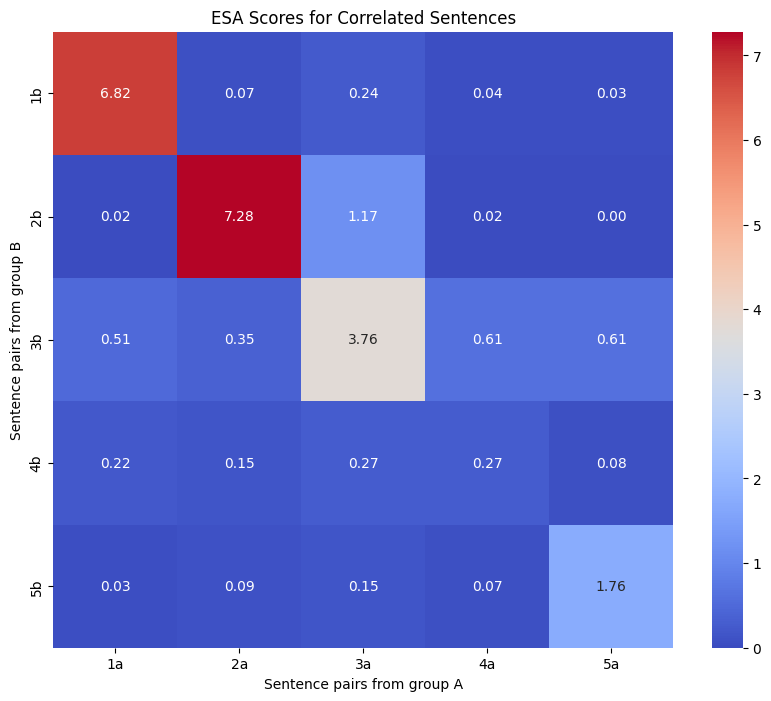

In [ ]:
import seaborn as sns

import matplotlib.pyplot as plt



# Data for heatmap

data = [

    [6.82, 0.07, 0.24, 0.04, 0.03],

    [0.02, 7.28, 1.17, 0.02, 0.00],

    [0.51, 0.35, 3.76, 0.61, 0.61],

    [0.22, 0.15, 0.27, 0.27, 0.08],

    [0.03, 0.09, 0.15, 0.07, 1.76]

]



# Setting up the labels for the axes

columns = ['1a', '2a', '3a', '4a', '5a']

rows = ['1b', '2b', '3b', '4b', '5b']



# Creating the heatmap

plt.figure(figsize=(10, 8))

sns.heatmap(data, annot=True, fmt=".2f", xticklabels=columns, yticklabels=rows, cmap="coolwarm")

plt.title('ESA Scores for Correlated Sentences')

plt.xlabel('Sentence pairs from group A')

plt.ylabel('Sentence pairs from group B')



# Display the heatmap

plt.show()